In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import helper
from matplotlib.lines import Line2D
import scipy.stats as stats

sns.set_style("ticks")
custom_palette = ["#2E610F", "#D9443D", "#7F5072", "#CFA97C", "#43383D"]
sns.set_palette(custom_palette)

In [2]:
processed_data_path = "data/processed/" 
output_path = "C:\\Users\\azgonnikov\\Dropbox\\Apps\\Overleaf\\AAP Dynamics of merging decisions Elsevier template"
data = pd.read_csv(os.path.join(processed_data_path, "processed_eye_data.csv"))
metrics = pd.read_csv(os.path.join(processed_data_path, "metrics.csv"))

# Figure 4

In [3]:
def plot_average_gaze(data, ax, plot_median_RT=False):
    average_gaze = data.groupby(["t"])[["is_looking_at_mirror", "is_looking_in_front", "is_looking_elsewhere"]].mean().reset_index()
    ax.fill_between(average_gaze.t, np.zeros(len(average_gaze)), average_gaze.is_looking_at_mirror, alpha=0.4, color="C2", label="Mirror")
    ax.fill_between(average_gaze.t, average_gaze.is_looking_at_mirror, average_gaze.is_looking_at_mirror+average_gaze.is_looking_in_front, alpha=0.4, color="C3", label="Front")
    ax.fill_between(average_gaze.t, average_gaze.is_looking_at_mirror+average_gaze.is_looking_in_front, average_gaze.is_looking_at_mirror+average_gaze.is_looking_in_front+average_gaze.is_looking_elsewhere, alpha=0.4, color="C4", label="Other")
    if plot_median_RT:
        median_rt = data.groupby(["participant", "trial"]).first().RT.mean() 
        ax.vlines(x=median_rt, ymin=0, ymax=1, color="grey", ls="--", alpha=0.4, label="Mean RT")

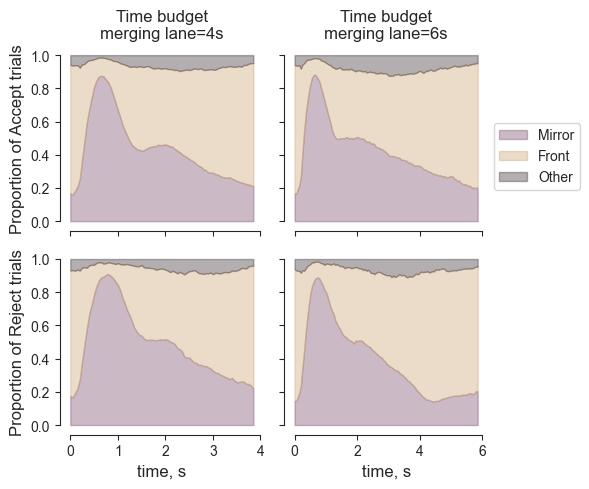

In [4]:
fontsize = 12
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(6,5), sharex="col", sharey="row")
plot_average_gaze(data[(data.decision=="Accept") &  (data.time_budget==4)], ax1)
plot_average_gaze(data[(data.decision=="Accept") & (data.time_budget==6)], ax2)
plot_average_gaze(data[(data.decision=="Reject") &  (data.time_budget==4)], ax3)
plot_average_gaze(data[(data.decision=="Reject") & (data.time_budget==6)], ax4)
ax1.set_title("Time budget\nmerging lane=4s", fontsize=fontsize)
ax1.set_ylabel("Proportion of Accept trials", fontsize=fontsize)
ax2.set_title("Time budget\nmerging lane=6s", fontsize=fontsize)
ax2.legend(bbox_to_anchor=(1., 0.4), loc="center left")
ax3.set_xlabel("time, s", fontsize=fontsize)
ax3.set_ylabel("Proportion of Reject trials", fontsize=fontsize)
ax4.set_xlabel("time, s", fontsize=fontsize)

sns.despine(trim=True, offset=1)
plt.tight_layout()
plt.savefig(os.path.join(output_path, "average_gaze_by_decision.pdf"), dpi=300, bbox_inches="tight")

# Figure 5

In [5]:
def plot_var_by_condition(metrics, var, include_legend=False, subfigure_labels=None, fig=None, axes=None):
    time_budgets = [4, 6]
    markers=["o", "s"]
    colors = ["C0", "C1"]
    fontsize=12
    ms=7

    if fig is None:
        fig, axes = plt.subplots(1, 2, figsize=(4,2), sharex=True, sharey=True)

    for tta, ax in zip([4, 6], axes):
        for time_budget, color, marker in zip(time_budgets, colors, markers):
            metrics_by_d = metrics[(metrics.tta == tta) & (metrics.time_budget == time_budget)]

            if var == "is_gap_accepted":
                psf_ci = helper.get_psf_ci(metrics_by_d)
                ax.plot(psf_ci.d, psf_ci.p_go, ls="-", marker=marker, ms=ms, color=color, zorder=10)
                ax.vlines(x=psf_ci.d, ymin=psf_ci.ci_l, ymax=psf_ci.ci_r, color=color, zorder=10)
                ax.set_ylim((0, 1))
            else:
                if var == "RT_accept":
                    measures_mean_sem = helper.get_mean_sem(metrics_by_d[metrics_by_d.is_gap_accepted],
                                                        var="RT", groupby_var="d", n_cutoff=10)
                elif var == "RT_reject":
                    measures_mean_sem = helper.get_mean_sem(metrics_by_d[~(metrics_by_d.is_gap_accepted)],
                                                        var="RT", groupby_var="d", n_cutoff=10)
                ax.errorbar(measures_mean_sem.index, measures_mean_sem["mean"], yerr=measures_mean_sem["sem"],
                                ls="-", marker=marker, ms=ms, color=color)

        ax.set_xlim((metrics_by_d.d.min()-5, metrics_by_d.d.max()+5))
        ax.set_title("TTA=%is" % (tta), fontsize=fontsize)

    if var=="is_gap_accepted":
        ylabel = "p(accept)"
        ylim = (0, 1)
    elif var=="RT_accept":
        ylabel = "accept RT"
        ylim = (1, 2)
    elif var=="RT_reject":
        ylabel = "reject RT"
        ylim = (1.5, 3)

    axes[0].set_title(subfigure_labels[0], loc="left", fontsize=fontsize)
    axes[1].set_title(subfigure_labels[1], loc="left", fontsize=fontsize)
    
    axes[0].set_ylabel(ylabel, fontsize=fontsize)

    for ax in axes:
        ax.set_ylim(ylim)

    if include_legend:
        fig.text(x=0.4, y=-0.02, s="Distance gap, m", fontsize=fontsize)
        legend_elements = ([Line2D([0], [0], color=color, marker=marker, ms=ms, lw=0, label="Time budget merging lane=%is" % (time_budget))
                           for time_budget, color, marker in zip(time_budgets, colors, markers)])

        fig.legend(handles=legend_elements, loc="lower left", bbox_to_anchor=(0.2, 1.00), fontsize=fontsize, frameon=False)

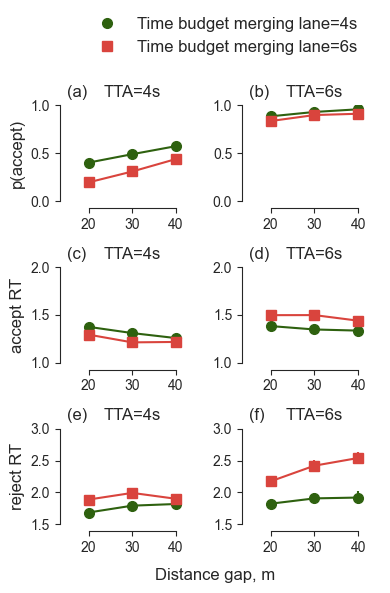

In [6]:
fig, axes = plt.subplots(3, 2, figsize=(4, 5))
plot_var_by_condition(metrics, var="is_gap_accepted", include_legend=True,subfigure_labels=["(a)", "(b)"], fig=fig, axes=axes[0])
plot_var_by_condition(metrics, var="RT_accept", include_legend=False,subfigure_labels=["(c)", "(d)"], fig=fig, axes=axes[1])
plot_var_by_condition(metrics, var="RT_reject", include_legend=False,subfigure_labels=["(e)", "(f)"], fig=fig, axes=axes[2])

plt.tight_layout()
sns.despine(offset=5, trim=True)

fig.set_tight_layout(True)
plt.savefig(os.path.join(output_path, "p_accept_RT.pdf"), bbox_inches="tight", dpi=300)

# Figure 6

In [7]:
mean_p_accept = data.groupby(["is_looking_at_mirror", "t", "tta"]).is_gap_accepted.mean().reset_index()

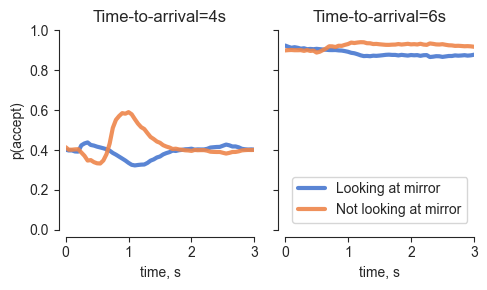

In [8]:
sns.set_palette(sns.color_palette("muted"))
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(5, 3))
for tta, ax in zip([4, 6], axes):
    data_to_plot = mean_p_accept[(mean_p_accept.tta==tta)] 
    ax.plot(data_to_plot[data_to_plot.is_looking_at_mirror].t, data_to_plot[data_to_plot.is_looking_at_mirror].is_gap_accepted, color="C0", alpha=0.9, lw=3, label="Looking at mirror")
    ax.plot(data_to_plot[~data_to_plot.is_looking_at_mirror].t, data_to_plot[~data_to_plot.is_looking_at_mirror].is_gap_accepted, color="C1", alpha=0.9, lw=3, label="Not looking at mirror")
    ax.set_xlim((0, 3))
    ax.set_ylim((0, 1.0))

axes[0].set_title("Time-to-arrival=4s")
axes[0].set_ylabel("p(accept)")
axes[1].set_title("Time-to-arrival=6s")
axes[1].legend(frameon=True)
axes[0].set_xlabel("time, s")
axes[1].set_xlabel("time, s")

sns.despine(trim=True, offset=5)
plt.tight_layout()
plt.savefig(os.path.join(output_path, "decision_vs_time.pdf"), bbox_inches="tight", dpi=300)

# Figure 7

In [9]:
mean_RTs = data.groupby(["decision", "is_looking_at_mirror", "t", "tta"]).RT.mean().reset_index()

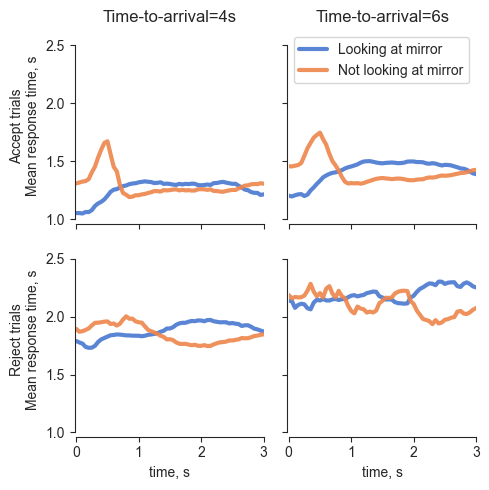

In [10]:
sns.set_palette(sns.color_palette("muted"))
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(5, 5))
for decision, ax_col in zip(["Accept", "Reject"], axes):
    for tta, ax in zip([4, 6], ax_col):
        data_to_plot = mean_RTs[(mean_RTs.tta==tta) & (mean_RTs.decision==decision)] 
        ax.plot(data_to_plot[data_to_plot.is_looking_at_mirror].t, data_to_plot[data_to_plot.is_looking_at_mirror].RT, color="C0", alpha=0.9, lw=3, label="Looking at mirror")
        ax.plot(data_to_plot[~data_to_plot.is_looking_at_mirror].t, data_to_plot[~data_to_plot.is_looking_at_mirror].RT, color="C1", alpha=0.9, lw=3, label="Not looking at mirror")
        ax.set_xlim((0, 3))

axes[0][0].set_title("Time-to-arrival=4s")
axes[0][0].set_ylabel("Accept trials\nMean response time, s")
axes[0][1].set_title("Time-to-arrival=6s")
axes[0][1].legend()
axes[1][0].set_xlabel("time, s")
axes[1][0].set_ylabel("Reject trials\nMean response time, s")
axes[1][1].set_xlabel("time, s")

sns.despine(trim=True, offset=1)
plt.tight_layout()
plt.savefig(os.path.join(output_path, "mean_rt_vs_time.pdf"), bbox_inches="tight", dpi=300)

# Figure 8

In [11]:
metrics["RT_decile"] = pd.qcut(metrics["RT"], q=10, precision=2)
metrics["dwell_mirror_tertile"] = pd.qcut(metrics["dwell_mirror"], q=3, precision=2)

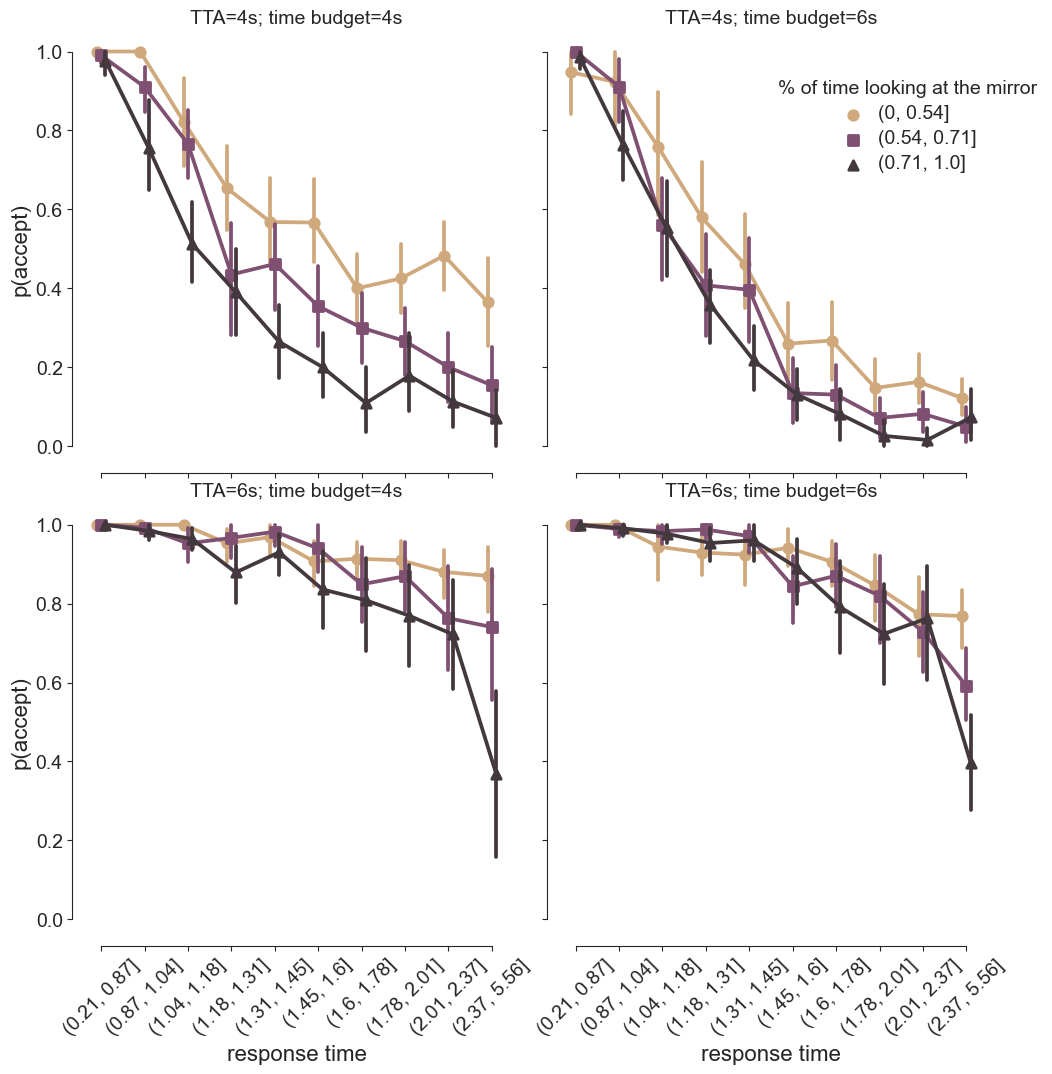

In [12]:
sns.set_palette(custom_palette)
fontsize = 14
height = 5
width = 5
ms = 9
markers=["o", "s", "^"]
colors = ["C3", "C2", "C4"]
tta_conditions = [4, 6]
time_budget_conditions = [4, 6]

g = sns.catplot(data=metrics, row="tta", col="time_budget", x="RT_decile", y="is_gap_accepted", hue="dwell_mirror_tertile", kind="point", dodge=0.2,
                markers=markers, palette=colors, height=height, aspect=width/height, legend_out=False)

for ax in g.axes.flatten():
    ax.xaxis.set_tick_params(rotation=45)    
    ax.set_xlabel("response time", fontsize=fontsize+2)
    ax.set_ylabel("p(accept)", fontsize=fontsize+2)    
    ax.tick_params(axis='both', which='major', labelsize=fontsize)

for ax_row, TTA in zip(g.axes, tta_conditions):
    for ax, time_budget in zip(ax_row, time_budget_conditions):
        ax.set_title("TTA=%is; time budget=%is" % (TTA, time_budget), fontsize=fontsize)
        # for dwell_mirror_tertile, color in zip(metrics.dwell_mirror_tertile.unique(), colors[::-1]):
        #     ax.axhline(metrics[(metrics.dwell_mirror_tertile==dwell_mirror_tertile) & 
        #                             (metrics.tta==TTA) &
        #                             (metrics.time_budget==time_budget)].is_gap_accepted.mean(), color=color, ls="--", lw=3)

sns.move_legend(g, "upper left", bbox_to_anchor=(.75, .93), frameon=False)
g.legend.set_title("% of time looking at the mirror")
g.legend.get_title().set_fontsize(fontsize)
for text in g.legend.get_texts():
    text.set_fontsize(fontsize)
    text.set_text(text.get_text().replace("-0.01", "0"))

sns.despine(offset=5, trim=True)
plt.savefig(os.path.join(output_path, "p_accept_dwell_RT.pdf"), bbox_inches="tight", dpi=300)

# Figure 9

In [13]:
participant_averages = metrics.groupby(["participant", "tta"])[["is_gap_accepted", "RT", "looked_at_mirror_early", "dwell_mirror"]].mean().reset_index()

decision 4 0.11821213365479087 0.5735847082253726
RT 4 -0.4096904201084871 0.041967111342987064
decision 6 -0.012400482284638602 0.9530873734565181
RT 6 -0.5098109754722707 0.009231513903919188


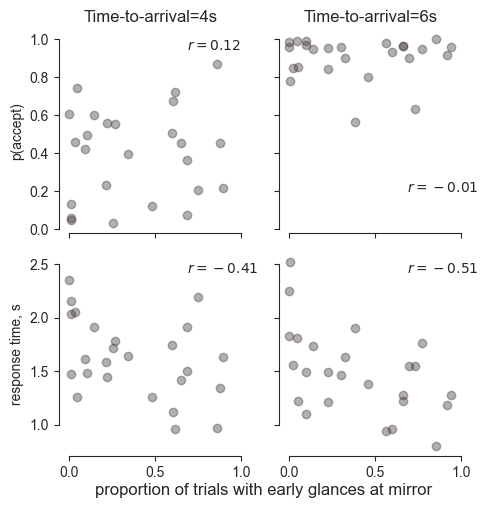

In [14]:
sns.set_palette(custom_palette)
fig, axes = plt.subplots(2, 2, sharex=True, sharey="row", figsize=(5, 5))

for tta, ax_row in zip([4, 6], axes.T):
    data_to_plot = participant_averages[participant_averages.tta==tta] 
    ax_row[0].scatter(data_to_plot.looked_at_mirror_early, data_to_plot.is_gap_accepted, color="C4", alpha=0.4)        
    decision_r, decision_p = stats.pearsonr(data_to_plot.looked_at_mirror_early, data_to_plot.is_gap_accepted)
    ax_row[0].annotate('$r= {:.2f}$'.format(decision_r), xy=(0.7, 0.9) if tta==4 else (0.7, 0.2), xycoords='axes fraction')
    print("decision", tta, decision_r, decision_p)
    
    ax_row[1].scatter(data_to_plot.looked_at_mirror_early, data_to_plot.RT, color="C4", alpha=0.4)
    rt_r, rt_p = stats.pearsonr(data_to_plot.looked_at_mirror_early, data_to_plot.RT)
    print("RT", tta, rt_r, rt_p)
    ax_row[1].annotate('$r= {:.2f}$'.format(rt_r), xy=(0.7, 0.9), xycoords='axes fraction')

for ax in axes.flatten():
    ax.set_xlim((-0.05, 1))
    
axes[0][0].set_title("Time-to-arrival=4s")
axes[0][0].set_ylabel("p(accept)")
axes[0][1].set_title("Time-to-arrival=6s")
axes[1][0].set_ylabel("response time, s")
fig.text(x=0.2, y=0.0, s="proportion of trials with early glances at mirror", fontsize=12)

sns.despine(trim=True, offset=1)
plt.tight_layout()
plt.savefig(os.path.join(output_path, "individual_diffs.pdf"), bbox_inches="tight", dpi=300)